# Compute $\hat{R}$ for $k$-commutativity with various molecules

## Setup

In [1]:
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif", "font.size": 12})
import numpy as np

import cirq
import openfermion
import openfermion as of

import quimb.tensor as qtn

from kcommute import get_si_sets, r_hat_measurement_count
from kcommute.commute import compute_blocks
from kcommute.shot_metrics import get_shotcounts_mpo_mps
from kcommute.tensor_nets import groups_of_to_mpos

### Set parameters

## Run script

In [2]:
all_groups = {}
all_rhats = {}

fname = "owp_631gd_22_ducc.data"
print("On molecule", fname)
# hamiltonian = read_openfermion_hdf5(
#     os.path.join(data_directory, fname),
#     encoding,
threshold_tolerance = 1e-2
ham_fermi = of.utils.load_operator(file_name=fname, data_directory=".")
hamiltonian = of.transforms.jordan_wigner(ham_fermi)
hamiltonian.compress(abs_tol=threshold_tolerance)

nq = openfermion.utils.count_qubits(hamiltonian)
qs = cirq.LineQubit.range(nq)
print(f"Hamiltonian has {nq} qubits and {len(hamiltonian.terms)} terms")

On molecule owp_631gd_22_ducc.data
Hamiltonian has 44 qubits and 4055 terms


In [3]:
qubits = cirq.LineQubit.range(nq)

max_mpo_bond = 5
max_mps_bond = 10
eps = 1e-3 # millihartree for chemical accuracy

# Generate a random state as an MPS.
psi = qtn.tensor_1d.MatrixProductState.from_fill_fn(
    lambda shape: np.random.rand(*shape), nq, bond_dim=max_mps_bond
)
psi.normalize()

k_values = [1, nq // 4, nq // 2, 3 * nq // 4, nq]
groups = []
rhats = []
shotcounts = []

for k in k_values:
    print("Status: k =", k)
    groups.append(get_si_sets(hamiltonian, compute_blocks(qubits, k), verbosity=1))
    rhats.append(r_hat_measurement_count(groups[-1]))
    # group_ops = [sum(group) for group in groups[-1]]
    # shotcounts.append(get_shotcounts_from_opsum(group_ops, psi, eps, nq))
    group_mpos = groups_of_to_mpos(groups[-1], qs, max_mpo_bond)
    shotcounts.append(get_shotcounts_mpo_mps(group_mpos, psi, eps))

    print("# groups =", len(groups[-1]))
    print("rhat =", rhats[-1])

all_groups[fname] = groups
all_rhats[fname] = rhats

/home/ryan/prof/work/wellcome/kcommute/envkcommute2/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Status: k = 1
# groups = 915li string 4053 / 4055
rhat = 26.69499303174824
Status: k = 11
# groups = 396li string 4053 / 4055
rhat = 48.88939954279451
Status: k = 22
# groups = 318li string 4053 / 4055
rhat = 56.19244601284366
Status: k = 33
# groups = 211li string 4053 / 4055
rhat = 72.92581010919982
Status: k = 44
# groups = 55uli string 4053 / 4055
rhat = 110.28586603880439


In [4]:
all_shotcounts = {}
all_shotcounts[fname] = shotcounts

## Plot results

In [5]:
all_ngroups = {fname: [len(group) for group in groups] for fname, groups in all_groups.items()}
all_ngroups

{'owp_631gd_22_ducc.data': [915, 396, 318, 211, 55]}

In [6]:
ngroups_to_plot = np.array(list(all_ngroups.values()))
ngroups_to_plot

array([[915, 396, 318, 211,  55]])

In [7]:
rhats_to_plot = np.array(list(all_rhats.values()))
rhats_to_plot

array([[ 26.69499303,  48.88939954,  56.19244601,  72.92581011,
        110.28586604]])

In [8]:
shotcounts_to_plot = np.array(list(all_shotcounts.values()))
shotcounts_to_plot

array([[1.33201703e+09, 6.71848726e+08, 5.60398455e+08, 3.98969082e+08,
        2.22007937e+08]])

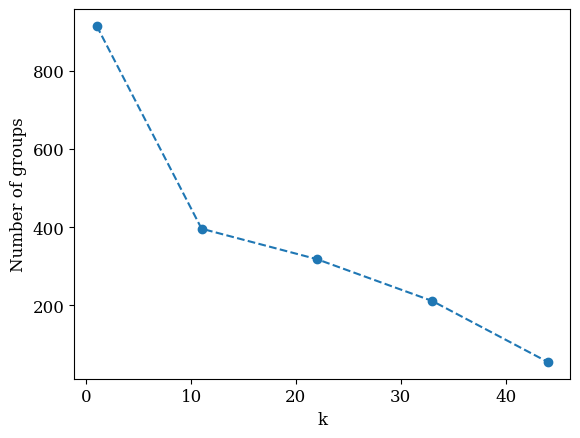

In [11]:
fig1, ax1 = plt.subplots()
ax1.plot(np.array(k_values), ngroups_to_plot.T, "--o")
ax1.set_xlabel("k")
ax1.set_ylabel("Number of groups");
# plt.savefig("hf_groups.pdf")

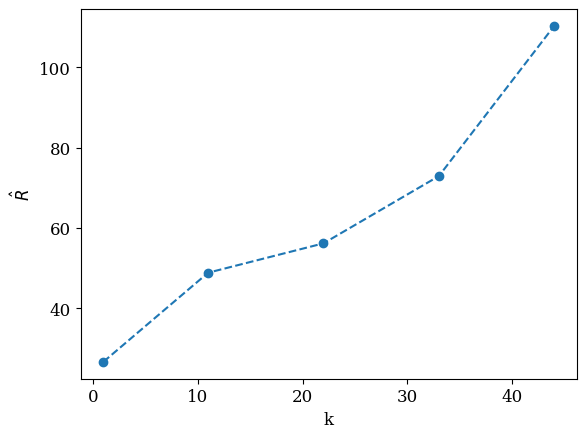

In [19]:
fig1, ax2 = plt.subplots()
ax2.plot(np.array(k_values), rhats_to_plot.T, "--o")
ax2.set_xlabel("k")
ax2.set_ylabel(r"$\hat{R}$");
# plt.savefig("hf_rhat.pdf")

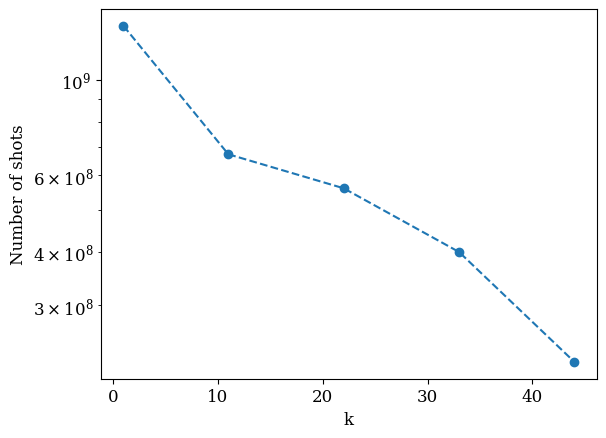

In [20]:
fig1, ax3 = plt.subplots()
ax3.plot(np.array(k_values), shotcounts_to_plot.T, "--o")
ax3.set_yscale("log")
ax3.set_xlabel("k")
ax3.set_ylabel("Number of shots");
# plt.savefig("hf_shots.pdf")